In [28]:
# Mawrer Amed Ramirez Martinez
# Avance de TOG IDI 4
# ms723737@iteso.mx

import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed 
set_random_seed(2)

from keras import backend as K

from statsmodels.tsa.arima_model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


import seaborn as sns
from scipy import stats

from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import plotly.graph_objects as go

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import tensorflow as tf 
from keras import metrics
from keras.callbacks import ModelCheckpoint

import pandas as pd
from pandas.plotting import autocorrelation_plot
import math as m
import os, glob

In [29]:

RANGE = 51

HYPER_L1_IN = RANGE
EPOCHS = 10
BATCH_SIZE = 32

TEST_SIZE = .19
VAL_SIZE = .0

START_IN = 50000
#total 99380

END_IN = 60000

TRAINING_TIME_ELAPSED = 0

TRAIN_MSE=0
TRAIN_RMSE=0
TRAIN_MAE=0
TEST_MSE=0
TEST_RMSE=0
TEST_MAE=0


In [30]:
#LOAD DATASET for ASK
# change column names
#load Dataset for BID
#change column names

pwd = os.getcwd()
source_data = os.path.join(pwd, r'../../Datasets/EURUSD/ene2004_nov2019/')
filenames = glob.glob(source_data + "/*.csv")
filenames.sort()
for file in filenames:
    print(os.path.basename(file))

dateparse = lambda x: pd.datetime.strptime(x, '%d.%m.%Y %H:%M:%S.%f')
DF_EURUSD_ASK = pd.read_csv(filenames[0], parse_dates=['Gmt time'], date_parser=dateparse, index_col=None, header=0)

#crear una nueva columna para asignar el formato de fecha
DF_EURUSD_ASK['Datetime'] = pd.to_datetime(DF_EURUSD_ASK['Gmt time'])
DF_EURUSD_ASK = DF_EURUSD_ASK.set_index('Datetime')
DF_EURUSD_ASK = DF_EURUSD_ASK.drop(['Gmt time'], axis = 1)

print(DF_EURUSD_ASK.columns)
print(DF_EURUSD_ASK.head())
print(DF_EURUSD_ASK.tail())
print(DF_EURUSD_ASK.dtypes)


EURUSD_ASK_01.01.2004-19.11.2019.csv
EURUSD_ASK_1_D_01.01.2004-19.11.2019.csv
EURUSD_ASK_1_H_01.01.2004-19.11.2019.csv
EURUSD_ASK_4_h_31.12.2003-18.11.2019.csv
procesado.csv
Index(['Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')
                        Open     High      Low    Close      Volume
Datetime                                                           
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25869  10003.0996
2004-01-01 04:00:00  1.25908  1.25960  1.25843  1.25950   7603.3999
                        Open     High      Low    Close     Volume
Datetime                                                          
2019-11-29 17:00:00  1.10192  1.10230  1.10163  1.10163  7553.0898
2019-11-29 18:00:00  1.10164  1.10236  1.10162  1.10173  3899.8999
2019-11-29 19:00

In [31]:
#Describe Dataframe ASK
print('Shape: ', DF_EURUSD_ASK.shape)
print(DF_EURUSD_ASK.describe())
print(DF_EURUSD_ASK.head())

Shape:  (99430, 5)
               Open          High           Low         Close         Volume
count  99430.000000  99430.000000  99430.000000  99430.000000   99430.000000
mean       1.269150      1.270197      1.268104      1.269151   21093.432064
std        0.121170      0.121347      0.120974      0.121171   33100.675536
min        1.035600      1.037040      1.034050      1.035630       0.380000
25%        1.168492      1.169320      1.167715      1.168473    5057.005000
50%        1.275570      1.276725      1.274450      1.275580   11830.814950
75%        1.353180      1.354100      1.352300      1.353170   25370.099600
max        1.601460      1.604030      1.598830      1.601570  491584.312500
                        Open     High      Low    Close      Volume
Datetime                                                           
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000
2004-01-01 02:00

In [32]:
start_time = datetime.strptime('2004-01-01', '%Y-%m-%d')
print(start_time)
end_time = datetime.strptime('2004-01-05', '%Y-%m-%d')
print(end_time)

date_rng = pd.date_range(start='2004-01-01 00:00:00', end='2004-01-05 12:00:00', freq='H')
date_rng

2004-01-01 00:00:00
2004-01-05 00:00:00


DatetimeIndex(['2004-01-01 00:00:00', '2004-01-01 01:00:00',
               '2004-01-01 02:00:00', '2004-01-01 03:00:00',
               '2004-01-01 04:00:00', '2004-01-01 05:00:00',
               '2004-01-01 06:00:00', '2004-01-01 07:00:00',
               '2004-01-01 08:00:00', '2004-01-01 09:00:00',
               ...
               '2004-01-05 03:00:00', '2004-01-05 04:00:00',
               '2004-01-05 05:00:00', '2004-01-05 06:00:00',
               '2004-01-05 07:00:00', '2004-01-05 08:00:00',
               '2004-01-05 09:00:00', '2004-01-05 10:00:00',
               '2004-01-05 11:00:00', '2004-01-05 12:00:00'],
              dtype='datetime64[ns]', length=109, freq='H')

In [33]:
DF_EURUSD_ASK = DF_EURUSD_ASK.sort_index(ascending=True)

In [34]:
# Igual que DF_EURUSD_ASK['Close'] / DF_EURUSD_ASK['Close'].shift(1) - 1 
DF_EURUSD_ASK['Pct_Range'] = DF_EURUSD_ASK['Close'].pct_change()
DF_EURUSD_ASK['Pct_Range'].fillna(0, inplace=True)
print(DF_EURUSD_ASK.head())
#DF_EURUSD_ASK['Pct_Range'].describe()

#movemos Shift -1 para tener el porcentaje que aumentara la siguinete hora
#DF_EURUSD_ASK.shift(-1)
DF_EURUSD_ASK['Pct_Range'] = DF_EURUSD_ASK['Pct_Range'].shift(-1)
DF_EURUSD_ASK['Pct_Range'].fillna(0, inplace=True)
print(DF_EURUSD_ASK.head())

                        Open     High      Low    Close      Volume  Pct_Range
Datetime                                                                      
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002   0.000000
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000   0.000326
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000   0.000000
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25869  10003.0996  -0.000651
2004-01-01 04:00:00  1.25908  1.25960  1.25843  1.25950   7603.3999   0.000644
                        Open     High      Low    Close      Volume  Pct_Range
Datetime                                                                      
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002   0.000326
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000   0.000000
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000  -0.000651
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25

In [35]:
DF_EURUSD_ASK['HL_PCT'] = (DF_EURUSD_ASK['High'] - DF_EURUSD_ASK['Low']) / DF_EURUSD_ASK['Close'] * 100.0
print(DF_EURUSD_ASK.head())

                        Open     High      Low    Close      Volume  \
Datetime                                                              
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002   
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000   
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000   
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25869  10003.0996   
2004-01-01 04:00:00  1.25908  1.25960  1.25843  1.25950   7603.3999   

                     Pct_Range    HL_PCT  
Datetime                                  
2004-01-01 00:00:00   0.000326  0.106425  
2004-01-01 01:00:00   0.000000  0.010321  
2004-01-01 02:00:00  -0.000651  0.014291  
2004-01-01 03:00:00   0.000644  0.104076  
2004-01-01 04:00:00   0.000040  0.092894  


In [36]:
print(DF_EURUSD_ASK['Pct_Range'].describe())

count    9.943000e+04
mean    -5.928003e-07
std      1.221789e-03
min     -2.035797e-02
25%     -4.835512e-04
50%      0.000000e+00
75%      4.883523e-04
max      2.303178e-02
Name: Pct_Range, dtype: float64


In [43]:
DF_EURUSD_ASK['Class'] = 0
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Pct_Range'] <= -0.0007, 'Class'] = -1
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Pct_Range'] >= 0.0007, 'Class'] = 1

DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Pct_Range'] <= -0.005, 'Class'] = -2
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Pct_Range'] >= 0.005 , 'Class'] = 2
print(DF_EURUSD_ASK.head())

                        Open     High      Low    Close      Volume  \
Datetime                                                              
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002   
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000   
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000   
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25869  10003.0996   
2004-01-01 04:00:00  1.25908  1.25960  1.25843  1.25950   7603.3999   

                     Pct_Range    HL_PCT  Class  
Datetime                                         
2004-01-01 00:00:00   0.000326  0.106425      0  
2004-01-01 01:00:00   0.000000  0.010321      0  
2004-01-01 02:00:00  -0.000651  0.014291      0  
2004-01-01 03:00:00   0.000644  0.104076      0  
2004-01-01 04:00:00   0.000040  0.092894      0  


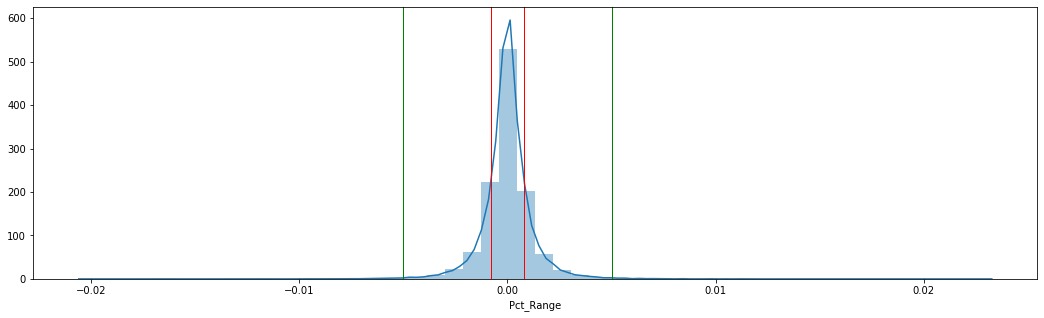

In [44]:
plt.figure(figsize=(18,5))
sns.distplot(DF_EURUSD_ASK['Pct_Range']);
plt.axvline(0.0008, 0, 1, linewidth=1, color='r')
plt.axvline(-0.0008, 0, 1, linewidth=1, color='r')
plt.axvline(0.005, 0, 1, linewidth=1, color='g')
plt.axvline(-0.005, 0, 1, linewidth=1, color='g')

In [45]:
DF_EURUSD_ASK['Sell'] = np.nan
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Class'] == -1, 'Sell'] = DF_EURUSD_ASK['Close']
DF_EURUSD_ASK['Sell2'] = np.nan
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Class'] <= -2, 'Sell2'] = DF_EURUSD_ASK['Close']

DF_EURUSD_ASK['Buy'] = np.nan
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Class'] >= 1, 'Buy'] = DF_EURUSD_ASK['Close']
DF_EURUSD_ASK['Buy2'] = np.nan
DF_EURUSD_ASK.loc[DF_EURUSD_ASK['Class'] >= 2, 'Buy2'] = DF_EURUSD_ASK['Close']

print(DF_EURUSD_ASK.head())

                        Open     High      Low    Close      Volume  \
Datetime                                                              
2004-01-01 00:00:00  1.25950  1.25960  1.25826  1.25910   6654.2002   
2004-01-01 01:00:00  1.25958  1.25960  1.25947  1.25951    660.6000   
2004-01-01 02:00:00  1.25955  1.25962  1.25944  1.25951   2091.0000   
2004-01-01 03:00:00  1.25950  1.25965  1.25834  1.25869  10003.0996   
2004-01-01 04:00:00  1.25908  1.25960  1.25843  1.25950   7603.3999   

                     Pct_Range    HL_PCT  Class  Sell  Sell2  Buy  Buy2  
Datetime                                                                 
2004-01-01 00:00:00   0.000326  0.106425      0   NaN    NaN  NaN   NaN  
2004-01-01 01:00:00   0.000000  0.010321      0   NaN    NaN  NaN   NaN  
2004-01-01 02:00:00  -0.000651  0.014291      0   NaN    NaN  NaN   NaN  
2004-01-01 03:00:00   0.000644  0.104076      0   NaN    NaN  NaN   NaN  
2004-01-01 04:00:00   0.000040  0.092894      0   NaN    N

In [46]:
print(DF_EURUSD_ASK['HL_PCT'].describe())

count    99430.000000
mean         0.163687
std          0.123191
min          0.000000
25%          0.085893
50%          0.131494
75%          0.202737
max          2.490464
Name: HL_PCT, dtype: float64


In [49]:
start_sub = 0
end_sub = 1000

data_daily_resampled = DF_EURUSD_ASK

fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=data_daily_resampled.index[start_sub:end_sub], y=data_daily_resampled['Close'][start_sub:end_sub],
                    mode='lines',
                    name='Close'))
fig.add_trace(go.Scatter(x=data_daily_resampled.index[start_sub:end_sub], y=data_daily_resampled['Sell'][start_sub:end_sub],
                    mode='markers',
                    name='Sell'))
fig.add_trace(go.Scatter(x=data_daily_resampled.index[start_sub:end_sub], y=data_daily_resampled['Buy'][start_sub:end_sub],
                    mode='markers',
                    name='Buy'))
fig.add_trace(go.Scatter(x=data_daily_resampled.index[start_sub:end_sub], y=data_daily_resampled['Sell2'][start_sub:end_sub],
                    mode='markers',
                    name='Sell2'))
fig.add_trace(go.Scatter(x=data_daily_resampled.index[start_sub:end_sub], y=data_daily_resampled['Buy2'][start_sub:end_sub],
                    mode='markers',
                    name='Buy2'))

fig.show()

In [17]:
data_daily_resampled = DF_EURUSD_ASK

fig = go.Figure()
# Add traces
fig.add_trace(go.Scatter(x=data_daily_resampled.index[:100], y=data_daily_resampled['Class'][:100],
                    mode='lines',
                    name='Close'))
fig.show()

In [27]:
pwd = os.getcwd()
path_filename = os.path.join(pwd, r'../../Datasets/EURUSD/ene2004_nov2019/procesado.csv')
print(path_filename)
DF_EURUSD_ASK.to_csv(path_filename,index=True)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/../../Datasets/EURUSD/ene2004_nov2019/procesado.csv


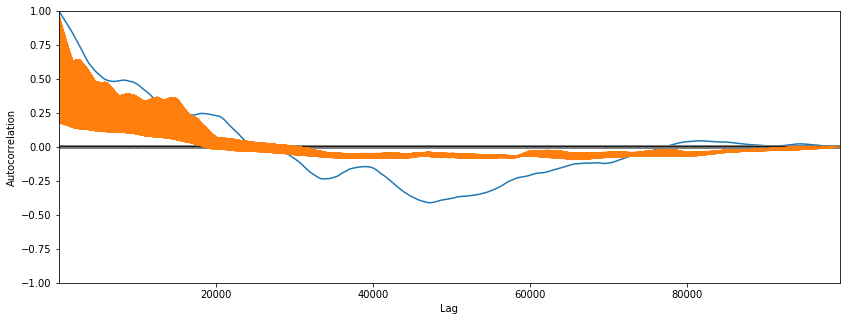

In [18]:
#Autocorrelation
plt.figure(figsize=(14,5))
autocorrelation_plot(DF_EURUSD_ASK['close_ask'])
autocorrelation_plot(DF_EURUSD_ASK['volume_ask'])
pyplot.show()

In [19]:
#HERE~~~~~~~~~~~~~~~~~~~~~


print(DF_EURUSD_ASK.shape)
DF_loc = DF_EURUSD_ASK.iloc[50:]
print(DF_loc)
print(DF_loc.shape)

(99430, 5)
       open_ask  high_ask  low_ask  close_ask   volume_ask
50      1.26602   1.26654  1.26418    1.26534   27811.9004
51      1.26522   1.26605  1.26486    1.26605   25342.3008
52      1.26591   1.26712  1.26566    1.26616   26680.3008
53      1.26623   1.26658  1.26511    1.26554   25238.4004
54      1.26566   1.26688  1.26541    1.26634   25252.4004
55      1.26639   1.26935  1.26565    1.26847   28269.6992
56      1.26805   1.26841  1.26325    1.26354   25556.0996
57      1.26343   1.26567  1.26340    1.26527   26884.6992
58      1.26540   1.26802  1.26533    1.26662   28066.9004
59      1.26661   1.26889  1.26623    1.26807   27132.8008
60      1.26815   1.26838  1.26684    1.26709   27606.5000
61      1.26713   1.26733  1.26438    1.26454   26476.0000
62      1.26448   1.26729  1.26415    1.26661   27262.1992
63      1.26665   1.26754  1.26503    1.26717   25770.0000
64      1.26708   1.26841  1.26610    1.26792  241983.0938
65      1.26802   1.26874  1.26733    1.26833

In [20]:
DF_Full = DF_loc
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)
print(DF_Full.columns)
print(DF_Full.head(10))

(99380, 5)
Index(['open_ask', 'high_ask', 'low_ask', 'close_ask', 'volume_ask'], dtype='object')
   open_ask  high_ask  low_ask  close_ask  volume_ask
0   1.26602   1.26654  1.26418    1.26534  27811.9004
1   1.26522   1.26605  1.26486    1.26605  25342.3008
2   1.26591   1.26712  1.26566    1.26616  26680.3008
3   1.26623   1.26658  1.26511    1.26554  25238.4004
4   1.26566   1.26688  1.26541    1.26634  25252.4004
5   1.26639   1.26935  1.26565    1.26847  28269.6992
6   1.26805   1.26841  1.26325    1.26354  25556.0996
7   1.26343   1.26567  1.26340    1.26527  26884.6992
8   1.26540   1.26802  1.26533    1.26662  28066.9004
9   1.26661   1.26889  1.26623    1.26807  27132.8008


In [21]:
total = DF_Full.shape[0]
print('Total: ', total)
print('Start: ', START_IN)
print('End: ', END_IN)


Total:  99380
Start:  50000
End:  60000


In [22]:
#Shape the first START of the total
DF_Full = DF_Full.iloc[START_IN:END_IN]
DF_Full.reset_index(drop=True, inplace=True) #reset indexes from iloc
print(DF_Full.shape)

(10000, 5)


In [23]:
total = DF_Full.shape[0]
print('Total: ', total)

Total:  10000


In [24]:
#generate the VECTOR Y
close_y = DF_Full['close_ask'].iloc[1:]
close_y.columns = ['close_y']
print(close_y.tail())
print(close_y.shape)
close_y = close_y.append(close_y.tail(1), ignore_index=True)
print(close_y.tail())
print(close_y.shape)


9995    1.32660
9996    1.32644
9997    1.32625
9998    1.32609
9999    1.32534
Name: close_ask, dtype: float64
(9999,)
9995    1.32644
9996    1.32625
9997    1.32609
9998    1.32534
9999    1.32534
Name: close_ask, dtype: float64
(10000,)


In [25]:
s1 = TEST_SIZE + VAL_SIZE
print('Sum of %s:',s1)
f1 = int(total * s1)
print('count of Val and Test:',f1)
end_train = total - f1
print('end of train: ', end_train)

count_val= int(total * VAL_SIZE)
print('count val: ',count_val)

count_test= int(total * TEST_SIZE)
print('count test: ',count_test)


end_val = end_train + count_val
print('end_val', end_val)



Sum of %s: 0.19
count of Val and Test: 1900
end of train:  8100
count val:  0
count test:  1900
end_val 8100


In [26]:
data_training = DF_Full.iloc[:end_train]
data_val = DF_Full.iloc[end_train: end_val]
data_test = DF_Full.iloc[end_val:]

print("Data Training Shape: ",data_training.shape)
print("Data Val Shape: ",data_val.shape)
print("Data Test Shape: ",data_test.shape)

data_training_y = close_y.iloc[:end_train]
data_val_y = close_y.iloc[end_train: end_val]
data_test_y = close_y.iloc[end_val:]
print("")
print("Y Data Training Shape: ", data_training_y.shape)
print("Y Data Val Shape: ", data_val_y.shape)
print("Y Data Test Shape: ", data_test_y.shape)

Data Training Shape:  (8100, 5)
Data Val Shape:  (0, 5)
Data Test Shape:  (1900, 5)

Y Data Training Shape:  (8100,)
Y Data Val Shape:  (0,)
Y Data Test Shape:  (1900,)


In [27]:
data_training_array = np.array(data_training)
#data_training_array = data_training_array.reset_index()
print(data_training_array.shape)
np.where(np.isnan(data_training_array))
#print(data_training_array.shape)
np.any(np.isnan(data_training_array))

(8100, 5)


False

In [28]:
# DATA SET SCALER TRAINING
scaler = MinMaxScaler(feature_range=(0, 1))
#print(data_training.head)
#data_training_array = np.array(data_training)
data_training_array_scaled = scaler.fit_transform(data_training_array)
print(data_training_array_scaled)
    

[[0.54154239 0.53992372 0.54335401 0.53900925 0.31714602]
 [0.53892507 0.53556511 0.5432324  0.53785297 0.24344896]
 [0.53789032 0.5480356  0.54353642 0.5540409  0.26861788]
 ...
 [0.68543429 0.68048913 0.68946856 0.68500487 0.13342817]
 [0.68500822 0.68024699 0.68843488 0.68634372 0.27017306]
 [0.68622558 0.68321327 0.69092789 0.68634372 0.25907974]]


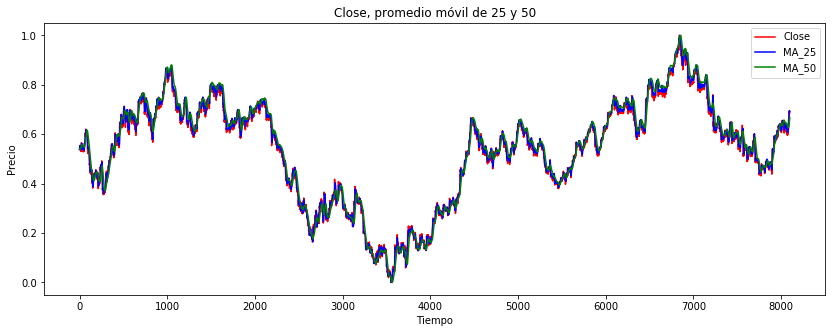

In [35]:
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[:,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[:,8], color = 'blue', label = 'MA_25')
pyplot.plot(data_training_array_scaled[:,9], color = 'green', label = 'MA_50')
plt.title('Close, promedio móvil de 25 y 50')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

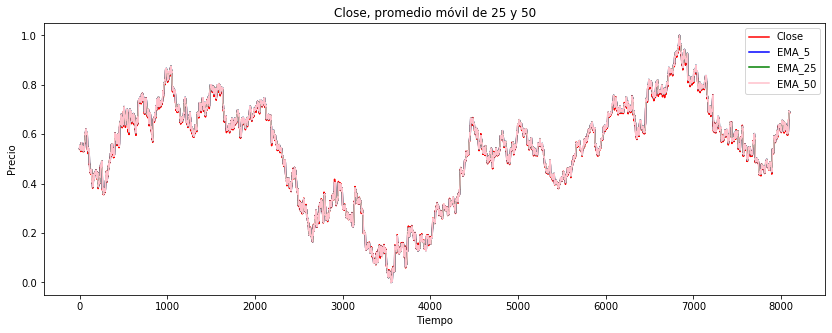

In [36]:
plt.figure(figsize=(14,5))
pyplot.plot(data_training_array_scaled[:,3], color = 'red', label = 'Close')
pyplot.plot(data_training_array_scaled[:,5], color = 'blue', label = 'EMA_5')
pyplot.plot(data_training_array_scaled[:,6], color = 'green', label = 'EMA_25')
pyplot.plot(data_training_array_scaled[:,7], color = 'pink', label = 'EMA_50')
plt.title('Close, promedio móvil de 25 y 50')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

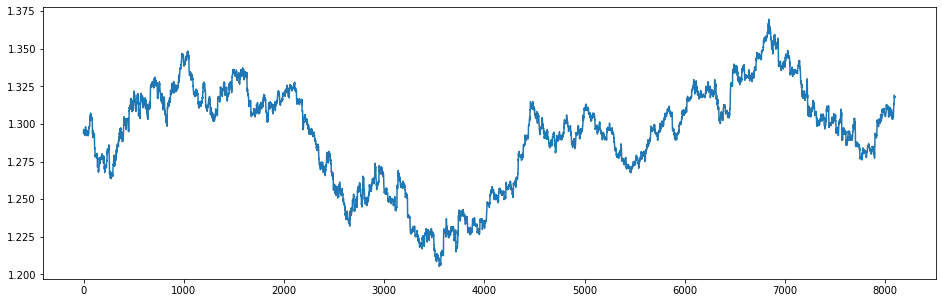

In [37]:
pyplot.figure(figsize=(16,5))
pyplot.plot(data_training_y)

In [38]:
X_train = []
y_train = []
for i in range(RANGE, data_training_array_scaled.shape[0]):
    X_train.append(data_training_array_scaled[i-RANGE:i])
    y_train.append(data_training_y[i])

X_train_np, y_train_np = np.array(X_train), np.array(y_train)

print(X_train_np.shape)
print(y_train_np.shape)

(8049, 51, 25)
(8049,)


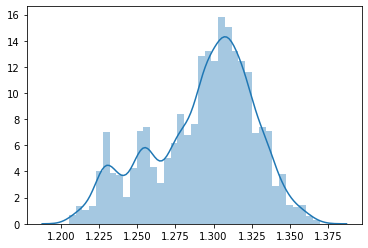

In [39]:
sns.distplot(y_train_np);



In [40]:

#Obtener los ultimos valores de Train para agregarlos a Val DF
# APPEND DE X
last_range_training_x = data_training.tail(RANGE)
print(last_range_training_x.shape)
print(data_val.shape)
data_val_x1 = last_range_training_x.append(data_val, ignore_index = True)
data_val_x1.shape
print(data_val_x1.head)

(51, 25)
(0, 25)
<bound method NDFrame.head of     open_ask  high_ask  low_ask  close_ask  volume_ask     EMA_5    EMA_25  \
0    1.31060   1.31060  1.30965    1.30970   4542.3198  1.310031  1.310031   
1    1.30971   1.31053  1.30933    1.31016   6093.7402  1.310117  1.310117   
2    1.31017   1.31080  1.30970    1.31044   5527.2202  1.310332  1.310332   
3    1.31044   1.31045  1.30722    1.30766  11074.8896  1.308551  1.308551   
4    1.30768   1.30801  1.30655    1.30775   8956.7900  1.308017  1.308017   
5    1.30775   1.30803  1.30701    1.30795   6308.7598  1.307972  1.307972   
6    1.30794   1.30826  1.30733    1.30734   5873.0400  1.307551  1.307551   
7    1.30733   1.30805  1.30652    1.30763  10327.3301  1.307604  1.307604   
8    1.30762   1.30925  1.30663    1.30745  15402.4297  1.307501  1.307501   
9    1.30747   1.30753  1.30530    1.30543  15774.9199  1.306120  1.306120   
10   1.30544   1.30763  1.30544    1.30640  14817.8301  1.306307  1.306307   
11   1.30638   1.

In [41]:
#Append de los datos de Train al DF de Val en Y
last_range_train_y = data_training_y.tail(RANGE)
print(last_range_train_y.shape)
print(data_val_y.shape)
data_val_y1 = last_range_train_y.append(data_val_y, ignore_index = True)
data_val_y1.shape
print(data_val_y1.head(10))

(51,)
(0,)
0    1.31016
1    1.31044
2    1.30766
3    1.30775
4    1.30795
5    1.30734
6    1.30763
7    1.30745
8    1.30543
9    1.30640
Name: close_ask, dtype: float64


In [42]:
data_val_x2 = scaler.transform(data_val_x1)
data_val_x2.shape
print(data_val_x2[:10])

[[0.64100067 0.633634   0.64088532 0.63552824 0.15471356 0.64097613
  0.64097613 0.64097613 0.6464139  0.64751357 0.65439214 0.58140162
  0.45110929 0.4917451  0.48502391 0.64415624 0.05665995 0.09386254
  0.63677494 0.62310315 0.64135493 0.61207487 0.64546709 0.58745645
  0.66359159]
 [0.63558342 0.63321024 0.63893956 0.63832765 0.20771764 0.64150524
  0.64150524 0.64150524 0.64624066 0.64712895 0.65485235 0.53153639
  0.44905505 0.50208301 0.47435113 0.64414553 0.05866635 0.33134498
  0.63691696 0.62529662 0.64206612 0.61367859 0.64408672 0.59094077
  0.66280979]
 [0.63838335 0.63484472 0.64118935 0.64003165 0.18836256 0.64282914
  0.64282914 0.64282914 0.64533733 0.64696847 0.65553478 0.51563342
  0.46713229 0.52815923 0.48581417 0.64500678 0.04572572 0.53466714
  0.6387835  0.62675228 0.64415906 0.61489116 0.64656327 0.59175064
  0.66540927]
 [0.64002678 0.63272595 0.62610969 0.62311344 0.37789797 0.63187708
  0.63187708 0.63187708 0.6411919  0.64600564 0.65589506 0.44501348
  0.40

In [43]:
X_val = []
y_val = []
for i in range(RANGE, data_val_x2.shape[0]):
    X_val.append(data_val_x2[i-RANGE:i])
    y_val.append(data_val_y1[i])

X_val_np = np.array(X_val)
y_val_np = np.array(y_val)
print(X_val_np.shape)
print(y_val_np.shape)

(0,)
(0,)


In [44]:

#Obtener los ultimos valores de Val para agregarlos a TEST DF
# Append en X
last_range_data_training_x = data_training.tail(RANGE)
print(last_range_data_training_x.shape)
print(data_test.shape)
data_test_x1 = last_range_data_training_x.append(data_test, ignore_index = True)
data_test_x1.shape


(51, 25)
(1900, 25)


(1951, 25)

In [45]:
#Append de los datos de Val al DF de Test de Y
last_range_training_y = data_training_y.tail(RANGE)
print(last_range_training_y.shape)
print(data_test_y.shape)
data_test_y1 = last_range_training_y.append(data_test_y, ignore_index = True)
data_test_y1.shape

(51,)
(1900,)


(1951,)

In [46]:
data_test_x2 = scaler.transform(data_test_x1)
data_test_x2.shape
print(data_test_x2[:10])

[[0.64100067 0.633634   0.64088532 0.63552824 0.15471356 0.64097613
  0.64097613 0.64097613 0.6464139  0.64751357 0.65439214 0.58140162
  0.45110929 0.4917451  0.48502391 0.64415624 0.05665995 0.09386254
  0.63677494 0.62310315 0.64135493 0.61207487 0.64546709 0.58745645
  0.66359159]
 [0.63558342 0.63321024 0.63893956 0.63832765 0.20771764 0.64150524
  0.64150524 0.64150524 0.64624066 0.64712895 0.65485235 0.53153639
  0.44905505 0.50208301 0.47435113 0.64414553 0.05866635 0.33134498
  0.63691696 0.62529662 0.64206612 0.61367859 0.64408672 0.59094077
  0.66280979]
 [0.63838335 0.63484472 0.64118935 0.64003165 0.18836256 0.64282914
  0.64282914 0.64282914 0.64533733 0.64696847 0.65553478 0.51563342
  0.46713229 0.52815923 0.48581417 0.64500678 0.04572572 0.53466714
  0.6387835  0.62675228 0.64415906 0.61489116 0.64656327 0.59175064
  0.66540927]
 [0.64002678 0.63272595 0.62610969 0.62311344 0.37789797 0.63187708
  0.63187708 0.63187708 0.6411919  0.64600564 0.65589506 0.44501348
  0.40

In [47]:
X_test = []
y_test = []
for i in range(RANGE, data_test_x2.shape[0]):
    X_test.append(data_test_x2[i-RANGE:i])
    y_test.append(data_test_y1[i])

X_test_np = np.array(X_test)
y_test_np = np.array(y_test)
print(X_test_np.shape)
print(y_test_np.shape)

(1900, 51, 25)
(1900,)


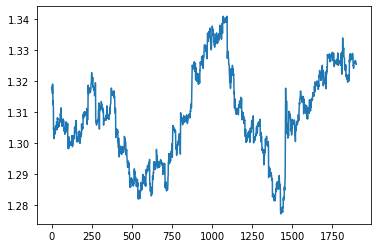

In [48]:
# Y del dataset de pruebas
pyplot.plot(y_test_np)

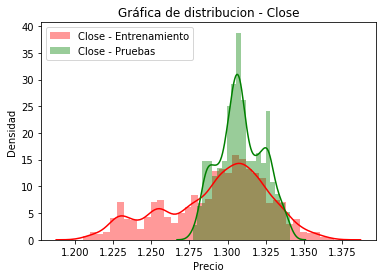

In [49]:
sns.distplot(y_train_np, color='red', label = 'Close - Entrenamiento');
sns.distplot(y_test_np, color='green', label = 'Close - Pruebas');
plt.title('Gráfica de distribucion - Close')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.legend()
plt.show()

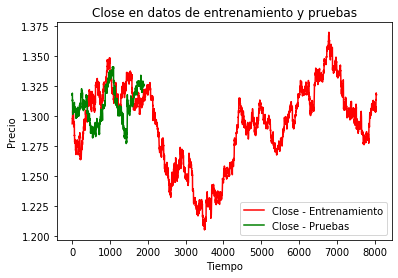

In [50]:

# Y de Val y Test comparados
pyplot.plot(y_train_np, color = 'red', label = 'Close - Entrenamiento')
#pyplot.plot(y_test_np)
pyplot.plot(y_test_np, color = 'green', label = 'Close - Pruebas')

plt.title('Close en datos de entrenamiento y pruebas')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [51]:
x_shape = X_train_np.shape[1]
print(x_shape)
y_shape = X_train_np.shape[2]
print(y_shape)

51
25


In [52]:
regressior = Sequential()

regressior.add(LSTM(units = RANGE, activation = 'relu', return_sequences = True, input_shape = (x_shape, y_shape)))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
#regressior.add(Dropout(0.2))

regressior.add(LSTM(units = 120, activation = 'relu'))
#regressior.add(Dropout(0.2))

regressior.add(Dense(units = 1))


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [53]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [54]:
regressior.compile(optimizer='adam', loss = 'mean_squared_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])

In [55]:
regressior.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 51, 51)            15708     
_________________________________________________________________
lstm_1 (LSTM)                (None, 51, 60)            26880     
_________________________________________________________________
lstm_2 (LSTM)                (None, 51, 80)            45120     
_________________________________________________________________
lstm_3 (LSTM)                (None, 120)               96480     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 184,309
Trainable params: 184,309
Non-trainable params: 0
_________________________________________________________________


In [56]:
#Model check pointer para almacenar el modelo cada epoca
checkpointer = ModelCheckpoint(filepath=source_data + '/model-{epoch:02d}.hdf5', verbose=1)

In [57]:
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[checkpointer])
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np), callbacks=[checkpointer], shuffle=True)
#history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_np, y_val_np))
history = regressior.fit(X_train_np, y_train_np, epochs=EPOCHS, batch_size=BATCH_SIZE)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 8049 samples
Epoch 1/10
8049/8049 [==============================] - 65s 8ms/sample - loss: 2.5062 - mean_squared_error: 2.5062 - mean_absolute_error: 0.2656 - mean_absolute_percentage_error: 20.5085 - cosine_proximity: 0.9920
Epoch 2/10
8049/8049 [==============================] - 48s 6ms/sample - loss: 8.6056e-05 - mean_squared_error: 8.6056e-05 - mean_absolute_error: 0.0074 - mean_absolute_percentage_error: 0.5736 - cosine_proximity: 1.0000
Epoch 3/10
8049/8049 [==============================] - 47s 6ms/sample - loss: 5.3575e-05 - mean_squared_error: 5.3575e-05 - mean_absolute_error: 0.0058 - mean_absolute_percentage_error: 0.4462 - cosine_proximity: 1.0000
Epoch 4/10
8049/8049 [==============================] - 48s 6ms/sample - loss: 4.5061e-05 - mean_squared_error: 4.5061e-05 - mean_absolute_error: 0.0053 - mean_absolute_percentage_error: 0.4135 - cosine_proximity: 1.0000
Epoch 5

In [58]:
MODEL_NAME = "03_marzo_model_24Features.hdf5"

regressior.save( source_data + MODEL_NAME)


In [59]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'cosine_proximity'])


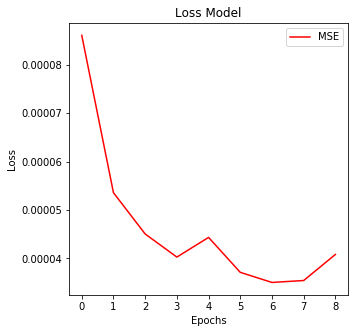

In [60]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
#plt.plot(history.history['val_loss'][1:], color = 'blue', label = 'Val_Loss')
plt.plot(history.history['mean_squared_error'][1:], color = 'red', label = 'MSE')
#plt.plot(history.history['mean_absolute_error'][1:], color = 'blue', label = 'MAE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

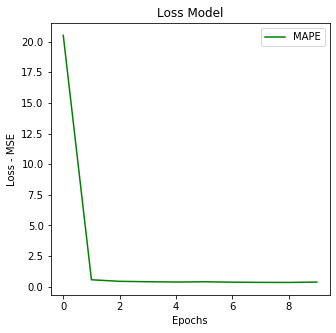

In [61]:
#PLOT MSE MAE
plt.figure(figsize=(5,5))
plt.plot(history.history['mean_absolute_percentage_error'][0:], color = 'green', label = 'MAPE')
plt.title('Loss Model')
plt.xlabel('Epochs')
plt.ylabel('Loss - MSE')
plt.legend()
plt.show()


In [62]:
#Load Model
#filepath = os.path.join(source_data, r'final_model_100Epochs_3Dic.hdf5')
filepath = os.path.join(source_data, MODEL_NAME)
print(filepath)
model = tf.keras.models.load_model(filepath)

/Users/marami3/Documents/ITESO/IDI4/forex_prediction/Jupyter Notebooks/IDI4/../../Datasets/EURUSD/ene2004_nov2019/03_marzo_model_24Features.hdf5
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [63]:
y_test_pred = model.predict(X_test_np)
y_test_pred.shape

(1900, 1)

In [64]:
y_train_pred = model.predict(X_train_np)
y_train_pred.shape

(8049, 1)

(1900,)
(1900, 1)


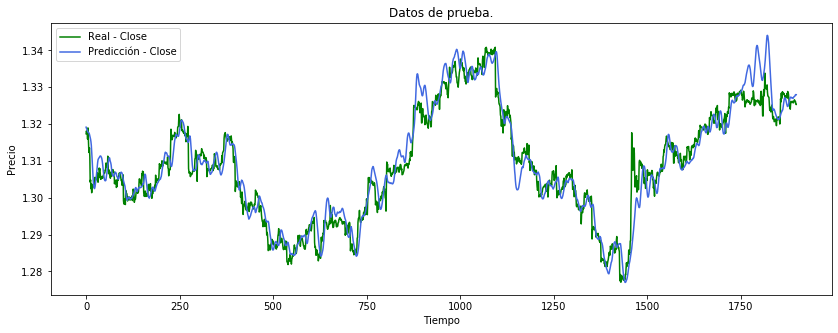

In [65]:
print(y_test_np.shape)
print(y_test_pred.shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np[:], color = 'green', label = 'Real - Close')
plt.plot(y_test_pred[:], color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de prueba.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [66]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [67]:
print('Test MAE:', mean_absolute_error(y_test_np, y_test_pred))#Mean Absolute Error
print('Test RMSE:',np.sqrt(mean_squared_error(y_test_np, y_test_pred)))#Root Mean Squared Error
print('Test MSE:',mean_squared_error(y_test_np, y_test_pred))#Mean Squared Error
print('Test MAPE:',mean_absolute_percentage_error(y_test_np, y_test_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_test_np, y_test_pred))#R2 Score


Test MAE: 0.0030538201579244496
Test RMSE: 0.004216986560213828
Test MSE: 1.7782975649024058e-05
Test MAPE: 1.2899097799107582
Test R2: 0.9149843173658393


(1899,)
(1899, 1)


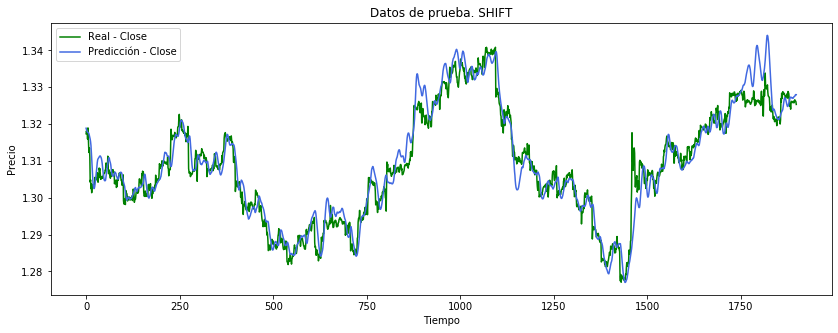

In [68]:
#shift 
y_test_np2 = np.delete(y_test_np, -1)


print(y_test_np2.shape)
print(y_test_pred[1:].shape)
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_test_np2, color = 'green', label = 'Real - Close')
plt.plot(y_test_pred[1:], color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de prueba. SHIFT')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()

In [69]:
#SHIFT
print('SHIFT Test MAE:', mean_absolute_error(y_test_np2, y_test_pred[1:]))#Mean Absolute Error
print('SHIFT Test RMSE:',np.sqrt(mean_squared_error(y_test_np2, y_test_pred[1:])))#Root Mean Squared Error
print('SHIFT Test MSE:',mean_squared_error(y_test_np2, y_test_pred[1:]))#Mean Squared Error
print('SHIFT Test MAPE:',mean_absolute_percentage_error(y_test_np2, y_test_pred[1:]))#Mean Absolute Percentaje Error
print('SHIFT Test R2:',r2_score(y_test_np2, y_test_pred[1:]))#R2 Score


SHIFT Test MAE: 0.002893921827765248
SHIFT Test RMSE: 0.00403510878207446
SHIFT Test MSE: 1.6282102883174427e-05
SHIFT Test MAPE: 1.2899133011994313
SHIFT Test R2: 0.9221463120970645


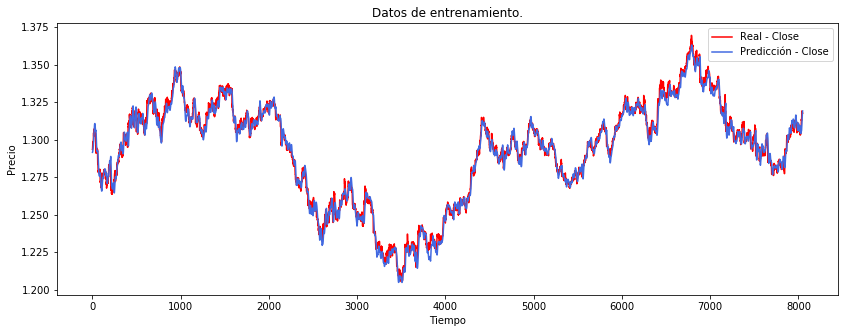

In [70]:
# Visualising the results
plt.figure(figsize=(14,5))
plt.plot(y_train_np, color = 'red', label = 'Real - Close')
plt.plot(y_train_pred, color = 'royalblue', label = 'Predicción - Close')
plt.title('Datos de entrenamiento.')
plt.xlabel('Tiempo')
plt.ylabel('Precio')
plt.legend()
plt.show()


In [71]:
print('Train MAE:', mean_absolute_error(y_train_np, y_train_pred))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(y_train_np, y_train_pred)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(y_train_np, y_train_pred))#Mean Squared Error
#print('Test MAPE:',mean_absolute_percentage_error(y_train_np, y_train_pred))#Mean Absolute Percentaje Error
print('Test R2:',r2_score(y_train_np, y_train_pred))#R2 Score
y_train_np2 = np.delete(y_train_np, -1)
print('Test R2 (-1):',r2_score(y_train_np2, y_train_pred[1:]))#R2 Score

Train MAE: 0.003043208069656189
Train RMSE: 0.004024262746297128
Train MSE: 1.6194690651234904e-05
Test R2: 0.9854059389537705
Test R2 (-1): 0.9871836395891759


In [237]:
# Section to implement the ARIMA model from the library statsmodels.tsa.arima_model
# fit model
#model = ARIMA(series, order=(5,1,0))
train, test = y_train_np, y_test_np
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)


/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/marami3/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimizat

Test MSE: 0.000


In [22]:
# plot
plt.figure(figsize=(14,5))
pyplot.plot(test[0:100], color='blue',label = 'Real - Close')
pyplot.plot(predictions[0:100], color='red',label = 'Prediction')
plt.title('ARIMA Model.')
plt.legend()
pyplot.show()

NameError: name 'test' is not defined

<Figure size 1008x360 with 0 Axes>

In [239]:
print('Train MAE:', mean_absolute_error(test, predictions))#Mean Absolute Error
print('Train RMSE:',np.sqrt(mean_squared_error(test, predictions)))#Root Mean Squared Error
print('Train MSE:',mean_squared_error(test, predictions))#Mean Squared Error

Train MAE: 0.0009024658862042764
Train RMSE: 0.0014721935197721378
Train MSE: 2.1673537596590758e-06
